In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
from astropy.table import Table
import emcee
import corner
from tqdm import *

In [2]:
## read the unsaturated sightlines' data in
#qtb = Table.read('tables/SiIV_measurement_newSNR_linear_083018.txt', format='ascii')
#ind = qtb['Q'] == 0
#qtb1 = qtb[ind]  # the remaining sightlines are saturated

#my_b = qtb1['b']
#my_l = qtb1['l']
#my_N = (qtb1['N1']+qtb1['N2'])/2.
#my_Ne = np.sqrt(qtb1['eN1']**2 + qtb1['eN2']**2)/2

#np.save('tables/SiIV_columndensity.npy', [my_b, my_l, my_N, my_Ne])

#### Plot the result to our data point

In [2]:
# model from mcmc_bootstrap_fig8n9n10
NDH_50 = 1.3*1e12
NDH_68up = 6.0e12
NDH_68low = 0.6e12


Nglo_50 = 3.4e13
Nglo_68up = 3.7e13
Nglo_68low = 3.1e13


galb = np.mgrid[0.1:90.1:1]
N50 = np.log10(NDH_50/np.sin(np.radians(galb)) + Nglo_50)
N68_up = np.log10(NDH_68up/np.sin(np.radians(galb)) + Nglo_68up)
N68_low = np.log10(NDH_68low/np.sin(np.radians(galb))+ Nglo_68low)

off_up = N68_up - N50
off_low = N68_low - N50

In [3]:
sigp = 1.4e13
mod_scat_up = np.log10(10**N50 + sigp)
mod_scat_low = np.log10(10**N50 - sigp)

off_scat_up = np.log10(10**N50 + sigp) - N50
off_scat_low = np.log10(10**N50 - sigp) - N50

In [4]:
# data/unsaturated sightlines 
qtb = Table.read('tables/Zheng18_Table1.fits', format='fits')
qtb_q0 = qtb[ qtb['Q']==0]
b_q0 = qtb_q0['Glat']
l_q0 = qtb_q0['Glon']
N_q0 = (qtb_q0['N_1393']+qtb_q0['N_1402'])/2.
Ne_q0 = np.sqrt(qtb_q0['Nsig_1393']**2 + qtb_q0['Nsig_1402']**2)/2
logN_q0 = np.log10(N_q0)
logNe_q0 = Ne_q0/N_q0/np.log(10)

datamod_q0 = logN_q0 - np.log10(NDH_50/np.sin(np.radians(np.fabs(b_q0)))+Nglo_50)
# datamod_q0 = N_q0 - (NDH_50/np.sin(np.radians(np.fabs(b_q0)))+Nglo_50)

in_q0 = np.any([l_q0>270, l_q0<90], axis=0)
out_q0 = np.all([l_q0>=90, l_q0<=270], axis=0)

# run spearman rank coefficient on the south and north offset datapoint separtately
from scipy.stats import spearmanr
aa = spearmanr(b_q0[b_q0>=0], datamod_q0[b_q0>=0])
bb = spearmanr(np.fabs(b_q0[b_q0<0]),  datamod_q0[b_q0<0])
cc = spearmanr(np.fabs(b_q0), datamod_q0)
print('North: ', aa)
print('South: ', bb)
print('All:   ', cc)

North:  SpearmanrResult(correlation=0.12228298017771702, pvalue=0.36928220314075755)
South:  SpearmanrResult(correlation=0.1270161290322581, pvalue=0.3211994717296501)
All:    SpearmanrResult(correlation=0.12605754166073213, pvalue=0.1719180706637774)


In [5]:
# data/saturated sightline 
qtb_q1 = qtb[qtb['Q']==1]
b_q1 = qtb_q1['Glat']
l_q1 = qtb_q1['Glon']
N_q1 = qtb_q1['N_1402']
Ne_q1 = qtb_q1['Nsig_1402']
logN_q1 = np.log10(N_q1)
logNe_q1 = Ne_q1/N_q1/np.log(10)

datamod_q1 = logN_q1 - np.log10(NDH_50/np.sin(np.radians(np.fabs(b_q1)))+Nglo_50)
# datamod_q1 = N_q1 - (NDH_50/np.sin(np.radians(np.fabs(b_q1)))+Nglo_50)

in_q1 = np.any([l_q1>270, l_q1<90], axis=0)
out_q1 = np.all([l_q1>=90, l_q1<=270], axis=0)

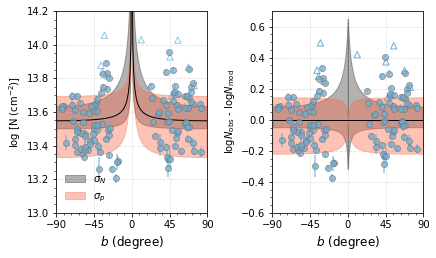

In [7]:
fig = plt.figure(figsize=(6, 3.5))

ax1 = fig.add_axes([0.12, 0.15, 0.35, 0.8])
ax2 = fig.add_axes([0.62, 0.15, 0.35, 0.8])
ax1.grid(linestyle='--', color=plt.cm.Greys(0.3), alpha=0.4)
ax2.grid(linestyle='--', color=plt.cm.Greys(0.3), alpha=0.4)

rr = plt.cm.Reds(0.5)
bb = plt.cm.Blues(0.5)
gg = plt.cm.Greens(0.5)
ms = 6
al = 0.7

ax1.errorbar(b_q0, logN_q0, yerr=logNe_q0, markersize=ms, marker='o', markeredgecolor=plt.cm.Greys(0.6), 
             linestyle='none', alpha=al, color=bb, label=None)
ax1.scatter(b_q1, logN_q1, marker='^', s=40, alpha=0.7, edgecolor=bb, facecolor='none', label=None)

ax1.plot(galb, N50, color='k', lw=1)
ax1.plot(-galb, N50, color='k', lw=1)
ax1.fill_between(galb, N68_low, N68_up, color='k', alpha=0.3, label=r'$\sigma_N$')
ax1.fill_between(-galb, N68_low, N68_up, color='k', alpha=0.3, label=None)
ax1.fill_between(galb, mod_scat_low, mod_scat_up, color=rr, alpha=0.4, label=r'$\sigma_p$')
ax1.fill_between(-galb, mod_scat_low, mod_scat_up, color=rr, alpha=0.4, label=None)
ax1.set_ylim(13.0, 14.2)
leg = ax1.legend(fontsize=10, loc='lower left')
leg.get_frame().set_linewidth(0.0)
leg.get_frame().set_facecolor('none')

##############################
ax2.errorbar(b_q0, datamod_q0, yerr=logNe_q0, markersize=ms, marker='o', color=bb,
             markeredgecolor=plt.cm.Greys(0.6), linestyle='none', alpha=al)
ax2.scatter(b_q1, datamod_q1, marker='^', s=40, edgecolor=bb, facecolor='none')

ax2.hlines(0, -90, 90, lw=1)
ax2.fill_between(galb, off_up, off_low, color='k', alpha=0.3, edgecolor='none')
ax2.fill_between(-galb, off_up, off_low, color='k', alpha=0.3, edgecolor='none')
ax2.fill_between(galb, off_scat_up, off_scat_low, color=rr, alpha=0.4, edgecolor='none')
ax2.fill_between(-galb, off_scat_up, off_scat_low, color=rr, alpha=0.4, edgecolor='none')
ax2.set_ylim(-0.6, 0.7)
for ax in [ax1, ax2]:
    ax.set_xlim(-90, 90)
    ax.set_xlabel(r'$b$ (degree)', fontsize=12)
    ax.set_xticks([-90, -45, 0, 45, 90])
    ax.minorticks_on()
    ax.grid(linestyle='--', color=plt.cm.Greys(0.4))
    
ax1.set_ylabel(r'log [N (cm$^{-2}$)]')
ax2.set_ylabel(r'log$N_{\rm obs}$ - log$N_{\rm mod}$')
fig.savefig('figs/fig10_bayesian_fit.pdf')